# Physics Informed Neural Networks: A Brief Introduction

#### Benjamin Whipple, Systems Medicine Lab, University of Idaho, 04/02/24

Here I provide a very brief introduction to physics informed neural networks.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#### Example 1: Simple 1D Poisson BVP Problem

We consider the simple 1d Poisson BVP problem given by $\frac{d^2u}{dx^2}=f(x)$ with $f(x)=-\pi^2\sin(\pi x)$, $u(0)=u(1)=0$.

This problem is advantageous to consider, because we can find $u(x)=\sin(\pi x)$ for verification purposes.

Note that for more complex problems we are generally not able to verify performance easily.

##### Defining the network architecture

In [15]:
class PINN(nn.Module):
    def __init__(self, num_neurons):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, num_neurons),  # Input layer
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),  # Hidden layer
            nn.Tanh(),
            nn.Linear(num_neurons, 1)  # Output layer
        )
    
    def forward(self, x):
        u = self.net(x)
        return u

    def loss_function(self, x, bc_coords, bc_vals):
        """Computes the PINN loss including boundary conditions"""
        # Differential equation loss
        u = self.forward(x)
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0] # This is how we take a first derivative
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0] # Note how we take higher derivatives
        f = -np.pi**2 * torch.sin(np.pi * x)
        pde_loss = torch.mean((u_xx - f) ** 2)

        # Boundary condition loss, you might implement this differently.
        u_bc = self.forward(bc_coords)
        bc_loss = torch.mean((u_bc - bc_vals) ** 2)

        # Total loss
        total_loss = pde_loss + bc_loss
        return total_loss


##### Initialize and Train

Epoch 0, Loss: 48.86481475830078
Epoch 500, Loss: 0.001164271030575037
Epoch 1000, Loss: 0.0008052715566009283
Epoch 1500, Loss: 0.0006109349196776748
Epoch 2000, Loss: 0.00041545447311364114
Epoch 2500, Loss: 0.00023540391703136265
Epoch 3000, Loss: 0.00015210486890282482
Epoch 3500, Loss: 0.00012183227227069438
Epoch 4000, Loss: 0.00010216802911600098
Epoch 4500, Loss: 8.730930858291686e-05


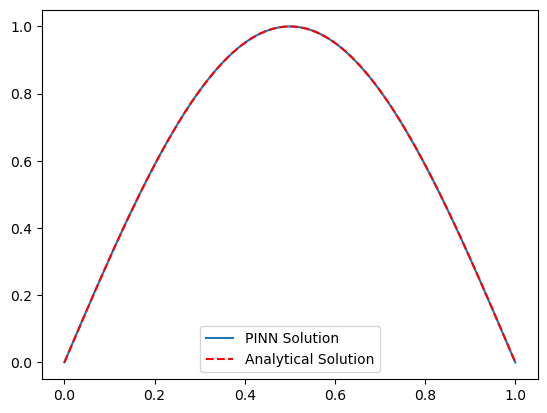

In [16]:
# Initialize the model
model = PINN(num_neurons=50)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training data (uniform points from 0 to 1)
x_train = torch.linspace(0, 1, steps=100, requires_grad=True).reshape(-1, 1)

# Boundary conditions
bc_coords = torch.tensor([0, 1], dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
bc_vals = torch.tensor([0, 0], dtype=torch.float32).reshape(-1, 1)

# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    loss = model.loss_function(x_train, bc_coords, bc_vals)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Plot the results
x_test = torch.linspace(0, 1, 100, requires_grad=False).reshape(-1, 1)
with torch.no_grad():
    u_pred = model(x_test).reshape(-1).numpy()

plt.plot(x_test.numpy(), u_pred, label='PINN Solution')
plt.plot(x_test.numpy(), np.sin(np.pi*x_test.numpy()), 'r--', label='Analytical Solution')
plt.legend()
plt.show()


##### Checking our results

We see that our method achieves good agreement with the known solution.

#### Example 2: Burger's Equation

A slightly more complicated example which is often considered for physics informed neural networks is Burger's equation. Burger's equation is a simple example of an equation which can result in shockwaves.

$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$



In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class BurgersPINN(nn.Module):
    def __init__(self, num_neurons):
        super(BurgersPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, num_neurons),  # Input layer for (x, t)
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),  # Hidden layer
            nn.Tanh(),
            nn.Linear(num_neurons, 1)  # Output layer for u
        )
    
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)  # Concatenate x and t
        u = self.net(xt)
        return u

    def loss_function(self, x, t, nu):
        u = self.forward(x, t)
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

        # Burgers' equation
        f = u_t + u * u_x - nu * u_xx
        mse_f = torch.mean(f ** 2)
        
        return mse_f


In [46]:
# Parameters
nu = 0.01/np.pi  # Viscosity
N_u = 100  # Number of data points for initial and boundary conditions
N_f = 1000  # Number of collocation points for PDE

# Initial condition points
x_initial = np.linspace(-1, 1, N_u)
t_initial = np.zeros(N_u)
u_initial = -np.sin(np.pi * x_initial)

# Boundary condition points
x_boundary = np.hstack([-np.ones(N_u), np.ones(N_u)])
t_boundary = np.linspace(0, 1, 2*N_u)
u_boundary = np.zeros(N_u * 2)

# Collocation points for PDE (x_f, t_f)
x_f = np.random.uniform(-1, 1, N_f)
t_f = np.random.uniform(0, 1, N_f)

# Convert to tensors
x_initial = torch.tensor(x_initial, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
t_initial = torch.tensor(t_initial, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
u_initial = torch.tensor(u_initial, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
x_boundary = torch.tensor(x_boundary, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
t_boundary = torch.tensor(t_boundary, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
u_boundary = torch.tensor(u_boundary, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
x_f = torch.tensor(x_f, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
t_f = torch.tensor(t_f, dtype=torch.float32, requires_grad=True).reshape(-1, 1)


In [52]:
# Initialize the model and optimizer
model = BurgersPINN(num_neurons=100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert initial and boundary data for training
x_bc = torch.cat([x_initial, x_boundary], dim=0)
t_bc = torch.cat([t_initial, t_boundary], dim=0)
u_bc = torch.cat([u_initial, u_boundary], dim=0)

# Training loop
import time
start = time.time()
for epoch in range(100000):
    optimizer.zero_grad()
    
    # Loss for collocation points
    mse_f = model.loss_function(x_f, t_f, nu)
    
    # Predictions for boundary and initial conditions
    u_pred = model(x_bc, t_bc)
    
    # Loss for boundary and initial conditions
    mse_bc = torch.mean((u_bc - u_pred) ** 2)
    
    # Total loss
    loss = mse_f + mse_bc
    
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
end = time.time()

print(f"Time taken: {end-start} seconds")

Epoch 0, Loss: 0.15686702728271484
Epoch 1000, Loss: 0.0380285307765007
Epoch 2000, Loss: 0.03134194761514664
Epoch 3000, Loss: 0.018139712512493134
Epoch 4000, Loss: 0.016817264258861542
Epoch 5000, Loss: 0.01662847027182579
Epoch 6000, Loss: 0.016479114070534706
Epoch 7000, Loss: 0.01635774038732052
Epoch 8000, Loss: 0.016065485775470734
Epoch 9000, Loss: 0.015540622174739838
Epoch 10000, Loss: 0.01431989949196577
Epoch 11000, Loss: 0.012713588774204254
Epoch 12000, Loss: 0.00991788413375616
Epoch 13000, Loss: 0.006298202555626631
Epoch 14000, Loss: 0.004417143762111664
Epoch 15000, Loss: 0.0035311745014041662
Epoch 16000, Loss: 0.006763022392988205
Epoch 17000, Loss: 0.002581130713224411
Epoch 18000, Loss: 0.0024123601615428925
Epoch 19000, Loss: 0.002552787773311138
Epoch 20000, Loss: 0.0024243060033768415
Epoch 21000, Loss: 0.0021259812638163567
Epoch 22000, Loss: 0.0020741864573210478
Epoch 23000, Loss: 0.0018985230708494782
Epoch 24000, Loss: 0.0033541652373969555
Epoch 25000, L

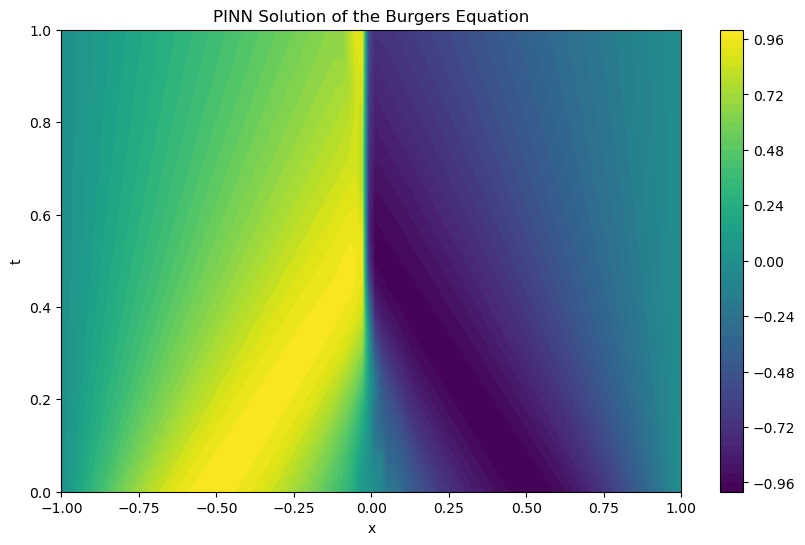

In [53]:
# Define the spatial and temporal domain
x = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 100)

# Create a meshgrid for (x, t)
X, T = np.meshgrid(x, t)
X_flat = X.flatten()
T_flat = T.flatten()

# Convert to torch tensors and ensure they are in the correct shape for the model
X_flat_torch = torch.tensor(X_flat, dtype=torch.float32).reshape(-1, 1)
T_flat_torch = torch.tensor(T_flat, dtype=torch.float32).reshape(-1, 1)

model.eval()
with torch.no_grad():
    U_pred = model(X_flat_torch, T_flat_torch).numpy()

# Plotting
plt.figure(figsize=(10, 6))
cp = plt.contourf(X, T, U_pred.reshape(X.shape), levels=50, cmap='viridis')
plt.colorbar(cp)  # Add a colorbar to a plot
plt.title('PINN Solution of the Burgers Equation')
plt.xlabel('x')
plt.ylabel('t')
plt.show()


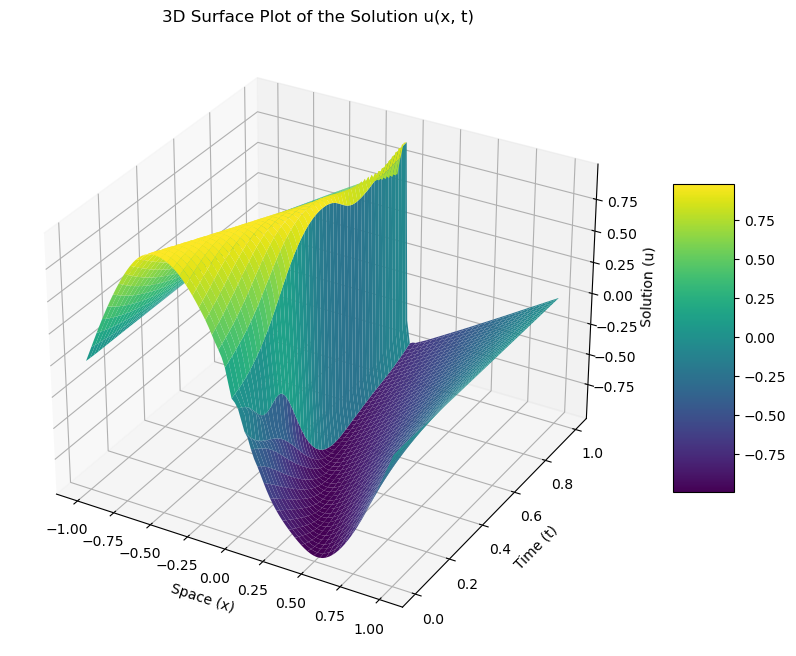

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure for 3D plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, T, U_pred.reshape(X.shape), cmap='viridis', edgecolor='none')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('Space (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Solution (u)')
ax.set_title('3D Surface Plot of the Solution u(x, t)')

plt.show()

We can see the shockwave at some $x-\epsilon$, which is expected.

Further resources on this PDE can be found at https://zingale.github.io/comp_astro_tutorial/advection_euler/burgers/burgers-methods.html

#### Conclusion

We have demonstrated the application of PINNs on two basic examples.

The examples we have considered are simple enough that traditional solvers have little problem solving them. As such, our exposition serves to demonstrate primarily the technique of PINN, rather than the advantages of PINN.

In practice, the advantage of PINNs is shown when the dimension N of the problem increases (think N>4). In these cases, most solvers will begin to suffer from the curse of dimensionality associated with spatial discretizations.